# Complete Meta-Learning Distribution

This notebook generates the complete meta-learning distribution for MetaChest.

In [1]:
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from common import ALIASES, filter_mset, plot_coocc, read_toml

## Generate

In [2]:
config = read_toml('config.toml')
mclasses = {'mtrn': config['mtrn'], 'mval': config['mval'], 'mtst': config['mtst']}
mclasses

{'mtrn': ['effusion',
  'lung_opacity',
  'atelectasis',
  'infiltration',
  'nodule',
  'mass',
  'pleural_thickening'],
 'mval': ['emphysema', 'fibrosis', 'hernia'],
 'mtst': ['cardiomegaly',
  'edema',
  'pneumothorax',
  'consolidation',
  'pneumonia']}

In [3]:
df = pd.read_csv(join(config['metachest_dir'], 'metachest.csv'))
df.head()

,dataset,name,age,sex,view,atelectasis,cardiomegaly,consolidation,edema,effusion,emphysema,fibrosis,hernia,infiltration,lung_opacity,mass,nodule,pleural_thickening,pneumonia,pneumothorax
0,chestxray14,00000001_000,57,m,pa,0,1,0,0,0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0
1,chestxray14,00000001_001,58,m,pa,0,1,0,0,0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0
2,chestxray14,00000001_002,58,m,pa,0,1,0,0,1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0,0
3,chestxray14,00000003_001,74,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0
4,chestxray14,00000003_002,75,f,pa,0,0,0,0,0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0,0


In [4]:
# name = 'complete'
# mclasses = MCLASSES
# metachest_dir = read_toml('config.toml')['metachest_dir']
# mtl_dir = join(metachest_dir, 'mtl')

# df = pd.read_csv(join(metachest_dir, 'metachest.csv'))

# filter_df = pd.DataFrame(
#     [[1, 1, 1]] * df.shape[0],
#     columns=mclasses.keys()
# )
# filter_msets(df, filter_df, mclasses)

# makedirs(join(mtl_dir), exist_ok=True)
# save_toml(join(mtl_dir, f'{name}.toml'), mclasses)
# filter_df.to_csv(join(mtl_dir, f'{name}.csv'), index=False)

## Exploration

In [5]:
print(f'Total {df.shape[0]}')
print(df['dataset'].value_counts())

Total 322475
dataset
chexpert       130930
mimic          111869
chestxray14     50651
padchest        29025
Name: count, dtype: int64


Compute total dataframe:

In [6]:
# group by dataset
paths = list(df.columns[5:])
ds_sum_df = df[['dataset'] + paths].groupby('dataset').sum().astype(int)
# sorted pathologies and datasets sseries
ds_sum_sr = ds_sum_df.sum(axis=1).sort_values(ascending=False)
pt_sum_sr = ds_sum_df.sum(axis=0).sort_values(ascending=False)
# sort grouped df
ds_sum_df = ds_sum_df.reindex(list(ds_sum_sr.index))
ds_sum_df = ds_sum_df[list(pt_sum_sr.index)]

# total df
total_df = ds_sum_df.copy()
total_df.loc[:, 'total'] = total_df.sum(axis=1)
total_df.loc['total', :] = total_df.sum(axis=0)
total_df = total_df.astype(int)

<Axes: >

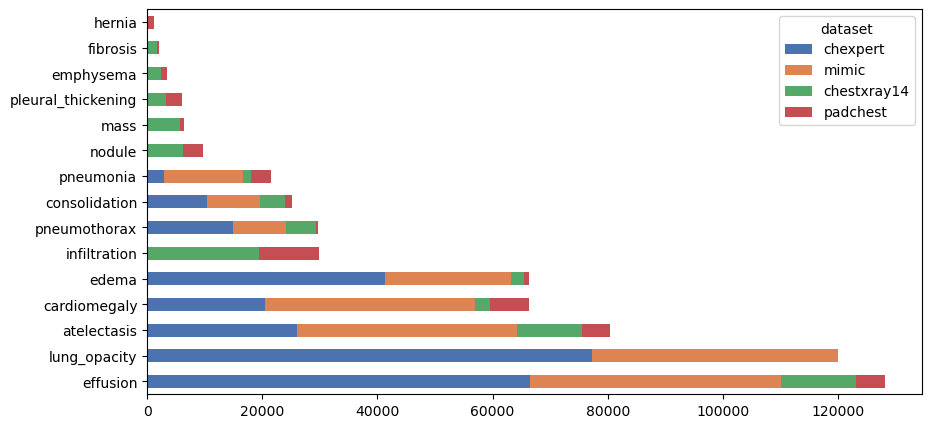

In [7]:
ds_sum_df.T.plot.barh(stacked=True, figsize=(10, 5),
                      color=sns.color_palette('deep'))

In [8]:
total_df.T.iloc[::-1]

dataset,chexpert,mimic,chestxray14,padchest,total
total,259599,215103,79436,42356,596494
hernia,0,0,197,1034,1231
fibrosis,0,0,1650,489,2139
emphysema,0,0,2484,939,3423
pleural_thickening,0,0,3326,2691,6017
mass,0,0,5682,738,6420
nodule,0,0,6238,3429,9667
pneumonia,2986,13679,1381,3548,21594
consolidation,10340,9183,4505,1197,25225
pneumothorax,14977,9215,5220,306,29718


### MTL Setup

In [9]:
mtrn, mval, mtst = mclasses.values()
mset_vals = ['mtrn'] * len(mtrn) + ['mval'] * len(mval) + ['mtst'] * len(mtst)
mset_df = total_df[mtrn + mval + mtst].T
mset_df.insert(0, 'mset', mset_vals)
mset_df

dataset,mset,chexpert,mimic,chestxray14,padchest,total
effusion,mtrn,66484,43544,13086,5075,128189
lung_opacity,mtrn,77194,42779,0,0,119973
atelectasis,mtrn,25980,38297,11335,4808,80420
infiltration,mtrn,0,0,19362,10455,29817
nodule,mtrn,0,0,6238,3429,9667
mass,mtrn,0,0,5682,738,6420
pleural_thickening,mtrn,0,0,3326,2691,6017
emphysema,mval,0,0,2484,939,3423
fibrosis,mval,0,0,1650,489,2139
hernia,mval,0,0,197,1034,1231


In [10]:
mset_df.groupby('mset', sort=False).sum()

dataset,chexpert,mimic,chestxray14,padchest,total
mset,,,,,
mtrn,169658,124620,59029,27196,380503
mval,0,0,4331,2462,6793
mtst,89941,90483,16076,12698,209198


Distribution per meta-set

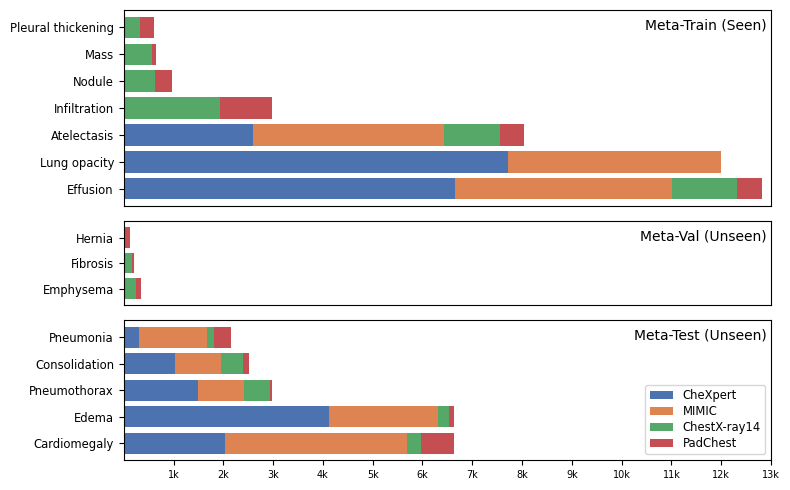

In [11]:
def plot_metasets(df, mclasses, figsize=(8, 5)):
    titles = ['Meta-Train (Seen) ', 'Meta-Val (Unseen) ', 'Meta-Test (Unseen) ']
    fig, axs = plt.subplots(
        nrows=len(mclasses), ncols=1, tight_layout=True,
        gridspec_kw={'height_ratios': [len(mset) for mset in mclasses]},
        figsize=figsize,
    )
    for mset, title, ax in zip(mclasses, titles, axs):
        ds_mset = df[mset]
        cols = {col: col.replace('_', ' ').capitalize() for col in ds_mset.columns}
        idxs = {'chexpert': 'CheXpert', 'mimic': 'MIMIC', 'chestxray14': 'ChestX-ray14', 'padchest': 'PadChest'}
        ds_mset = ds_mset.rename(columns=cols, index=idxs)
        ax = ds_mset.T.plot.barh(stacked=True, width=0.8, ax=ax,
                                 color=sns.color_palette('deep'))
        ax.set_xticks([],[])
        ax.set_title(title, fontsize=10, loc='right', y=1.0, pad=-14)
        ax.set_xlim(0, 130000)
        if 'Test' in title:
            ax.legend(loc='lower right', fontsize='small', labelspacing=0.25)
        else:
            ax.get_legend().remove()
        ax.tick_params(axis='y', which='major', labelsize='small')
    xticks = [x for x in range(10000, 130001, 10000)]
    ax.set_xticks(xticks, [f'{x//10000}k' for x in xticks], fontsize=7)

plot_metasets(ds_sum_df, mclasses.values())

Plot correlation matrices per meta-set.

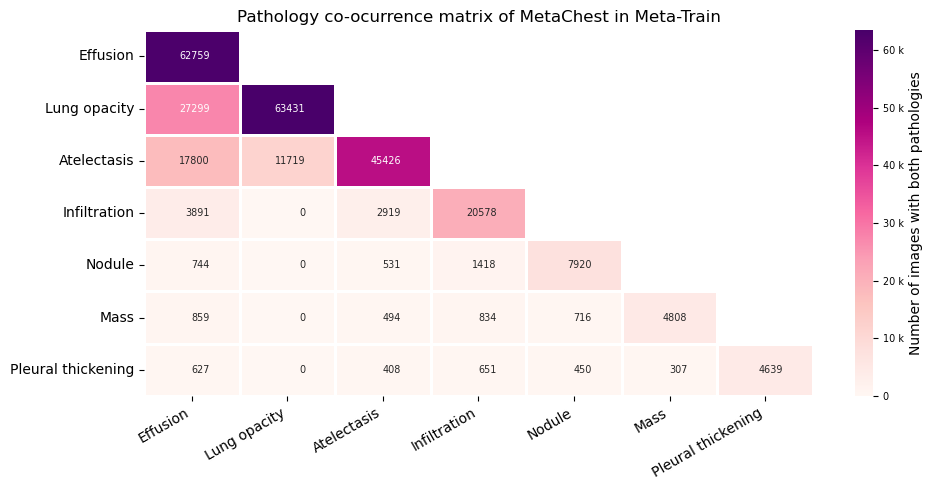

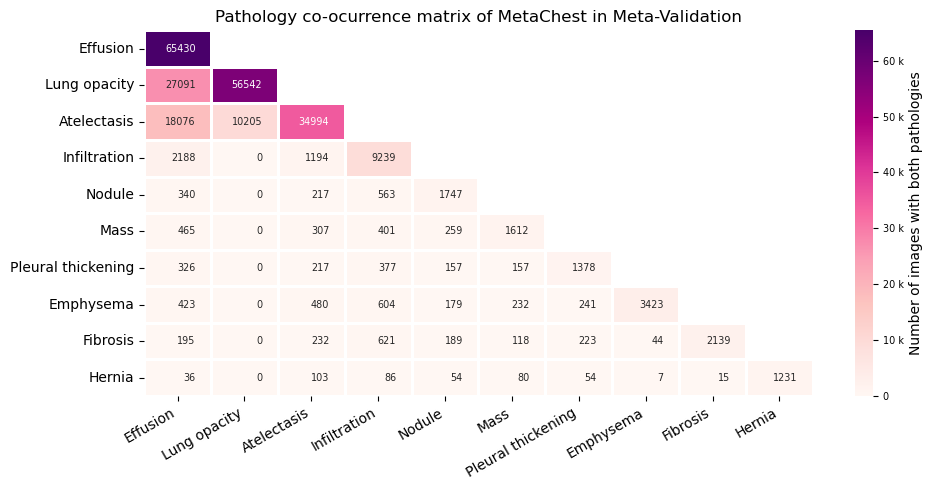

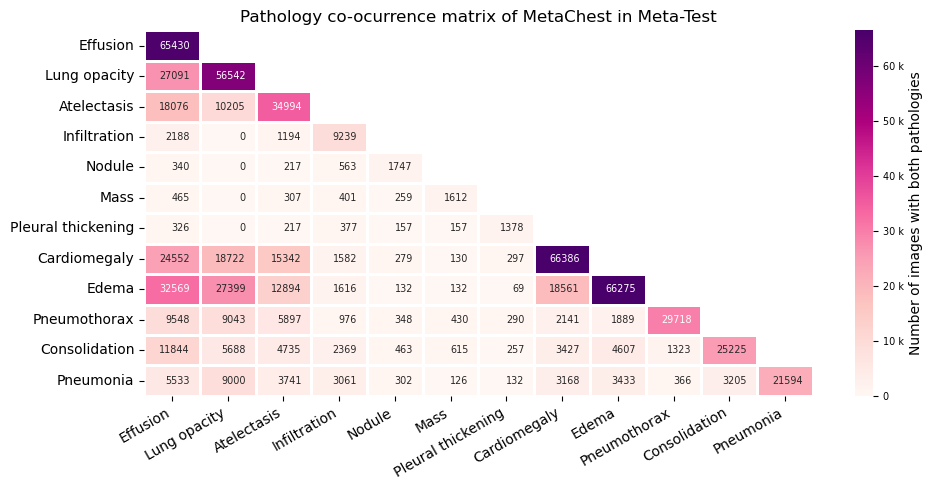

In [12]:
for mset in ('mtrn', 'mval', 'mtst'):
    mset_df = filter_mset(mset, mclasses, df)
    plot_coocc('MetaChest', mset, mset_df.iloc[:, 5:])